In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch                                                

from utils import retrieve_user_imgs, compute_img_rating_statistics, plot_user_images, plot_filtered_images, compute_similarity_matrix, plot_similarity_matrix
import PIL


import matplotlib.pyplot as plt

In [3]:
# Tensor
image_features = torch.load("../data/flickr/processed/image_features.pt")
# Pandas dataframe
ratings_df = pd.read_csv("../data/flickr/processed/ratings.csv")

In [5]:
len(ratings_df)

193208

In [6]:
ratings_df.head()

,Unnamed: 0,worker,imagePair,score,worker_id,image_id
0,0,A14W0IW2KGR80K,farm1_176_396297967_94dae8ad97.jpg,2,0,0
1,1,A14W0IW2KGR80K,farm1_106_268532564_c273eb23e6.jpg,4,0,1
2,2,A14W0IW2KGR80K,farm8_7224_7246491674_540646a594.jpg,4,0,2
3,3,A14W0IW2KGR80K,farm3_2643_4041742092_25f170c501.jpg,2,0,3
4,4,A14W0IW2KGR80K,farm4_3080_2922825219_1ba9c41b1a.jpg,5,0,4


## Worker Statistics

In [4]:
worker_statistics_df = ratings_df.groupby("worker_id")["score"].agg(["count", "min", "mean", "median", "max", "std"]).reset_index()

<Figure size 1200x800 with 0 Axes>

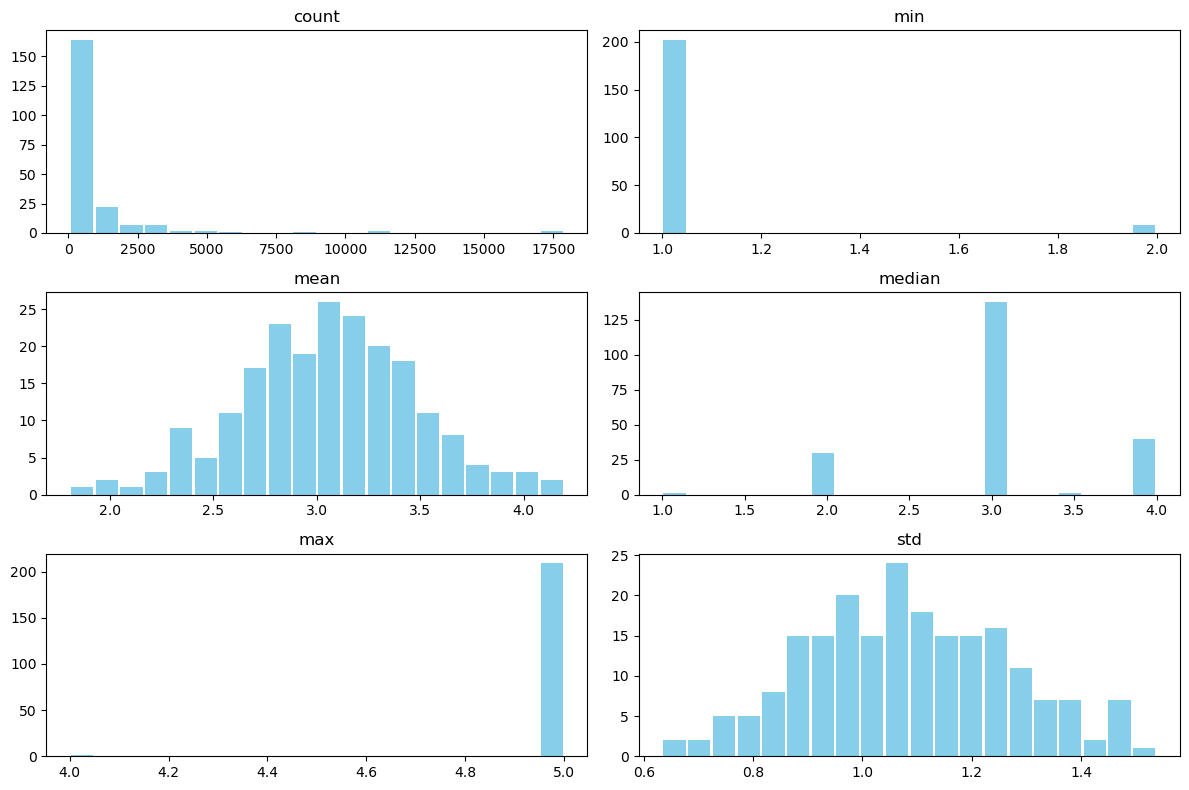

In [5]:
plt.figure(figsize=(12, 8))
worker_statistics_df.loc[:, worker_statistics_df.columns != "worker_id"].hist(bins=20, grid=False, figsize=(12, 8), color='skyblue', zorder=2, rwidth=0.9)
plt.tight_layout()
plt.show()

In [6]:
worker_statistics_df.sort_values("count")

,worker_id,count,min,mean,median,max,std
185,185,48,1,2.375000,2.0,5,1.044234
63,63,49,1,3.163265,3.0,5,1.230632
44,44,50,2,3.080000,3.0,5,0.633745
94,94,51,1,2.862745,3.0,5,1.456291
172,172,52,1,3.615385,4.0,5,1.140242
...,...,...,...,...,...,...,...
98,98,8084,1,2.960416,3.0,5,0.907400
42,42,11084,1,2.946951,3.0,5,0.984075
46,46,11363,1,3.357740,3.0,5,0.751621
193,193,17340,1,2.393772,2.0,5,0.761453


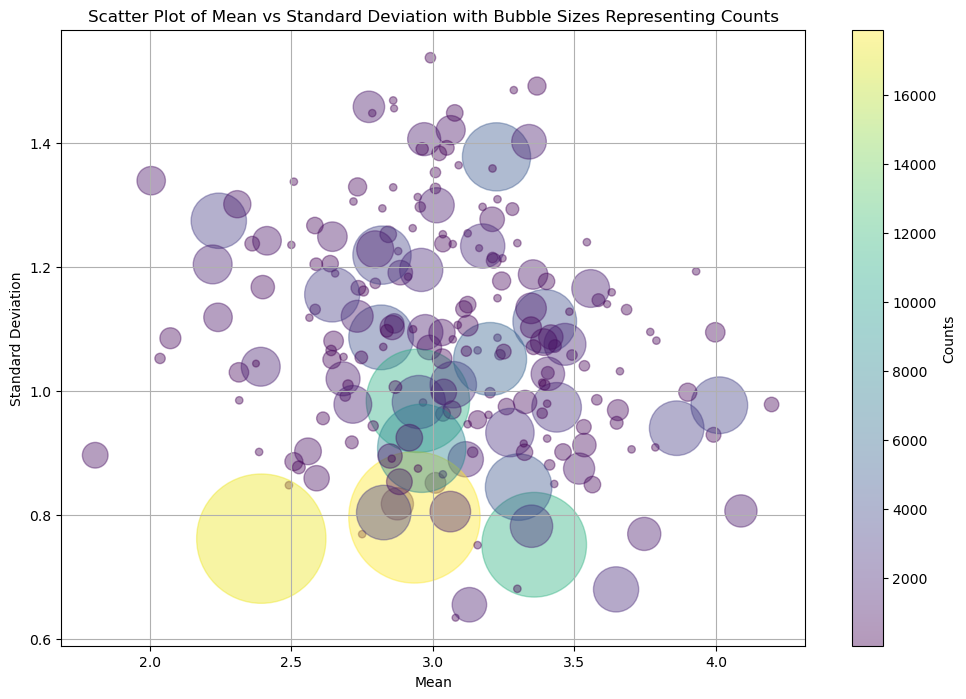

In [7]:
means = worker_statistics_df['mean']  # Assuming 'mean' is a column for mean values
stds = worker_statistics_df['std']    # Assuming 'std' is a column for standard deviations
counts = worker_statistics_df['count']  # Assuming 'count' is a column for counts

# Normalize counts to a reasonable size for plotting
# Using logarithmic scale to normalize sizes
#sizes = (np.log(counts) - np.log(counts.min())) / (np.log(counts.max()) - np.log(counts.min())) * 990 + 10
sizes = counts

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(means, stds, s=sizes/2, c=sizes, alpha=0.4)
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
plt.title('Scatter Plot of Mean vs Standard Deviation with Bubble Sizes Representing Counts')
plt.colorbar(label='Counts')  # Optional: colorbar to represent the scaling of counts
plt.grid(True)
plt.show()

In [ ]:
user_0_imgs = retrieve_user_imgs(0, ratings_df)
user_1_imgs = retrieve_user_imgs(1, ratings_df)
user_2_imgs = retrieve_user_imgs(2, ratings_df)
user_3_imgs = retrieve_user_imgs(3, ratings_df)
user_4_imgs = retrieve_user_imgs(4, ratings_df)
user_185_imgs = retrieve_user_imgs(185, ratings_df)
user_1_imgs

,worker_id,image_id,imagePair,score
3178,1,3328,farm1_27_96361207_c200595017.jpg,5
3179,1,3329,farm9_8257_10242112923_e28dbbb8b5.jpg,5
3180,1,3330,farm9_8120_8660284278_4889403113.jpg,5
3181,1,3332,farm3_2883_10242111223_02f6db5bd9.jpg,5
3182,1,3333,farm4_3289_2692130376_ed293af7a1.jpg,3
...,...,...,...,...
3344,1,3502,farm1_180_440368873_d6bd86c4fe.jpg,1
3345,1,3503,farm5_4068_4660807708_9219a5925c.jpg,4
3346,1,3504,farm5_4037_4237248070_9af9c65ce8.jpg,4
3347,1,3505,farm8_7099_7237068024_53196e8ec0.jpg,4


In [28]:
from utils import plot_generated_images

worker_id_mapping = pd.read_csv("../data/flickr/processed/worker_id_mapping_usrthr_100.csv")
worker_id_mapping[worker_id_mapping["old_worker_id"] == 42]["worker_id"].item()

def plot_comparison(gt_image_dir, test_image_dir, worker_id, n=20):
    old_worker_id = worker_id_mapping[worker_id_mapping["worker_id"] == worker_id]["old_worker_id"].item()
    selected_images = retrieve_user_imgs(old_worker_id, ratings_df)
    user_df = selected_images[selected_images["score"] >= 4]
    plot_user_images(image_dir=gt_image_dir, user_df=user_df, n=n)
    user_gen_image_dir = f"{test_image_dir}/user_{worker_id}/images"
    plot_generated_images(user_gen_image_dir, n=n)

    return user_df

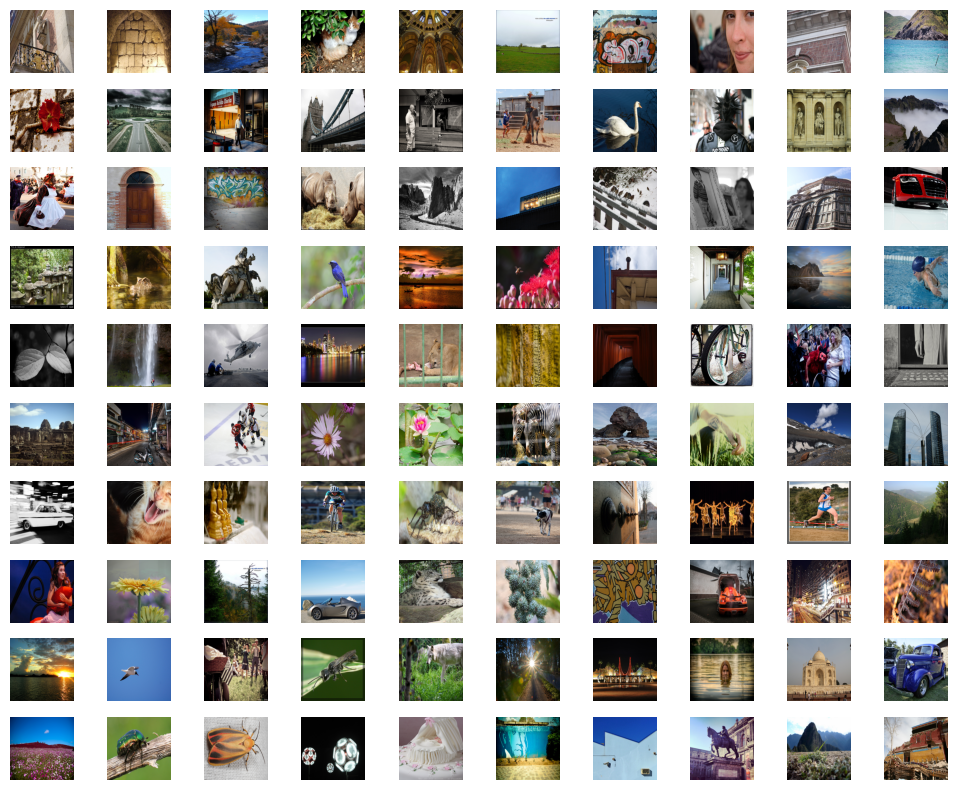

Requested number of images reduced to 50 due to limited generated images.


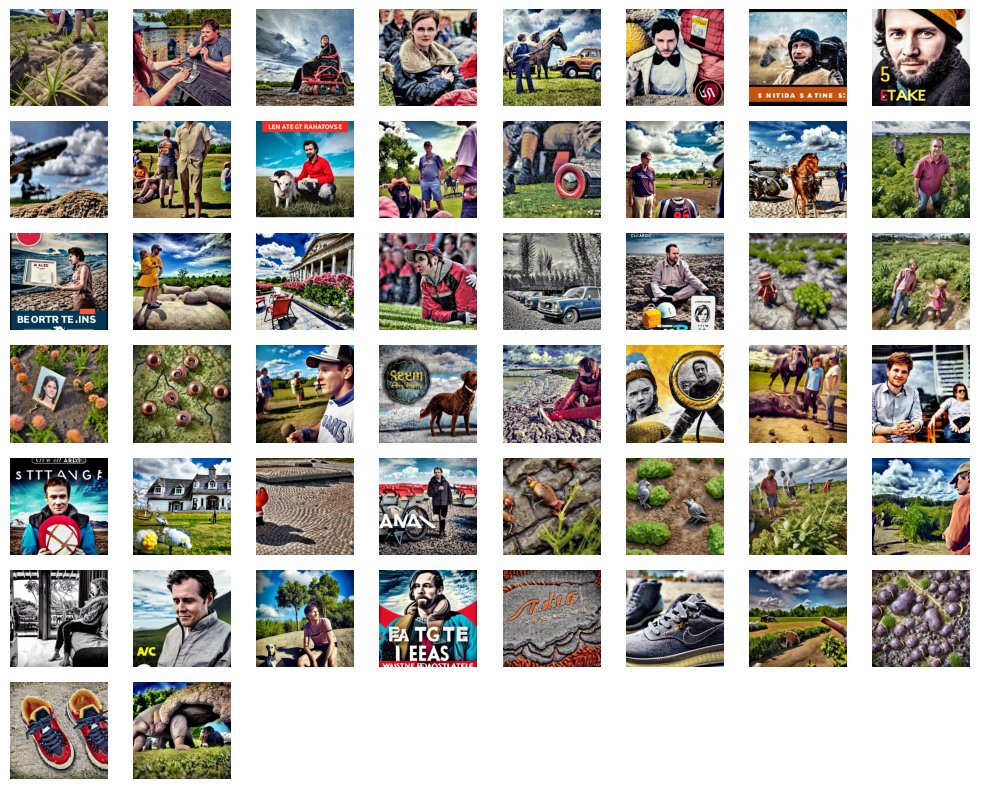

In [29]:
user_df = plot_comparison(
    gt_image_dir="../data/flickr/raw/40K/", 
    test_image_dir="../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0__NEG__usrthres_100_v1",
    worker_id=20,
    n=100,
    )

In [32]:
user_df

from utils import store_eval_images_per_user

store_eval_images_per_user(liked_df=user_df,
                           src_dir="../data/flickr/raw/40K/",
                           dst_base_dir="./")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hohlx\\Desktop\\regenesys\\regenesys\\notebooks\\data\\raw\\FLICKR-AES-001\\40K\\farm3_2426_3871852648_85e149d4e1.jpg'

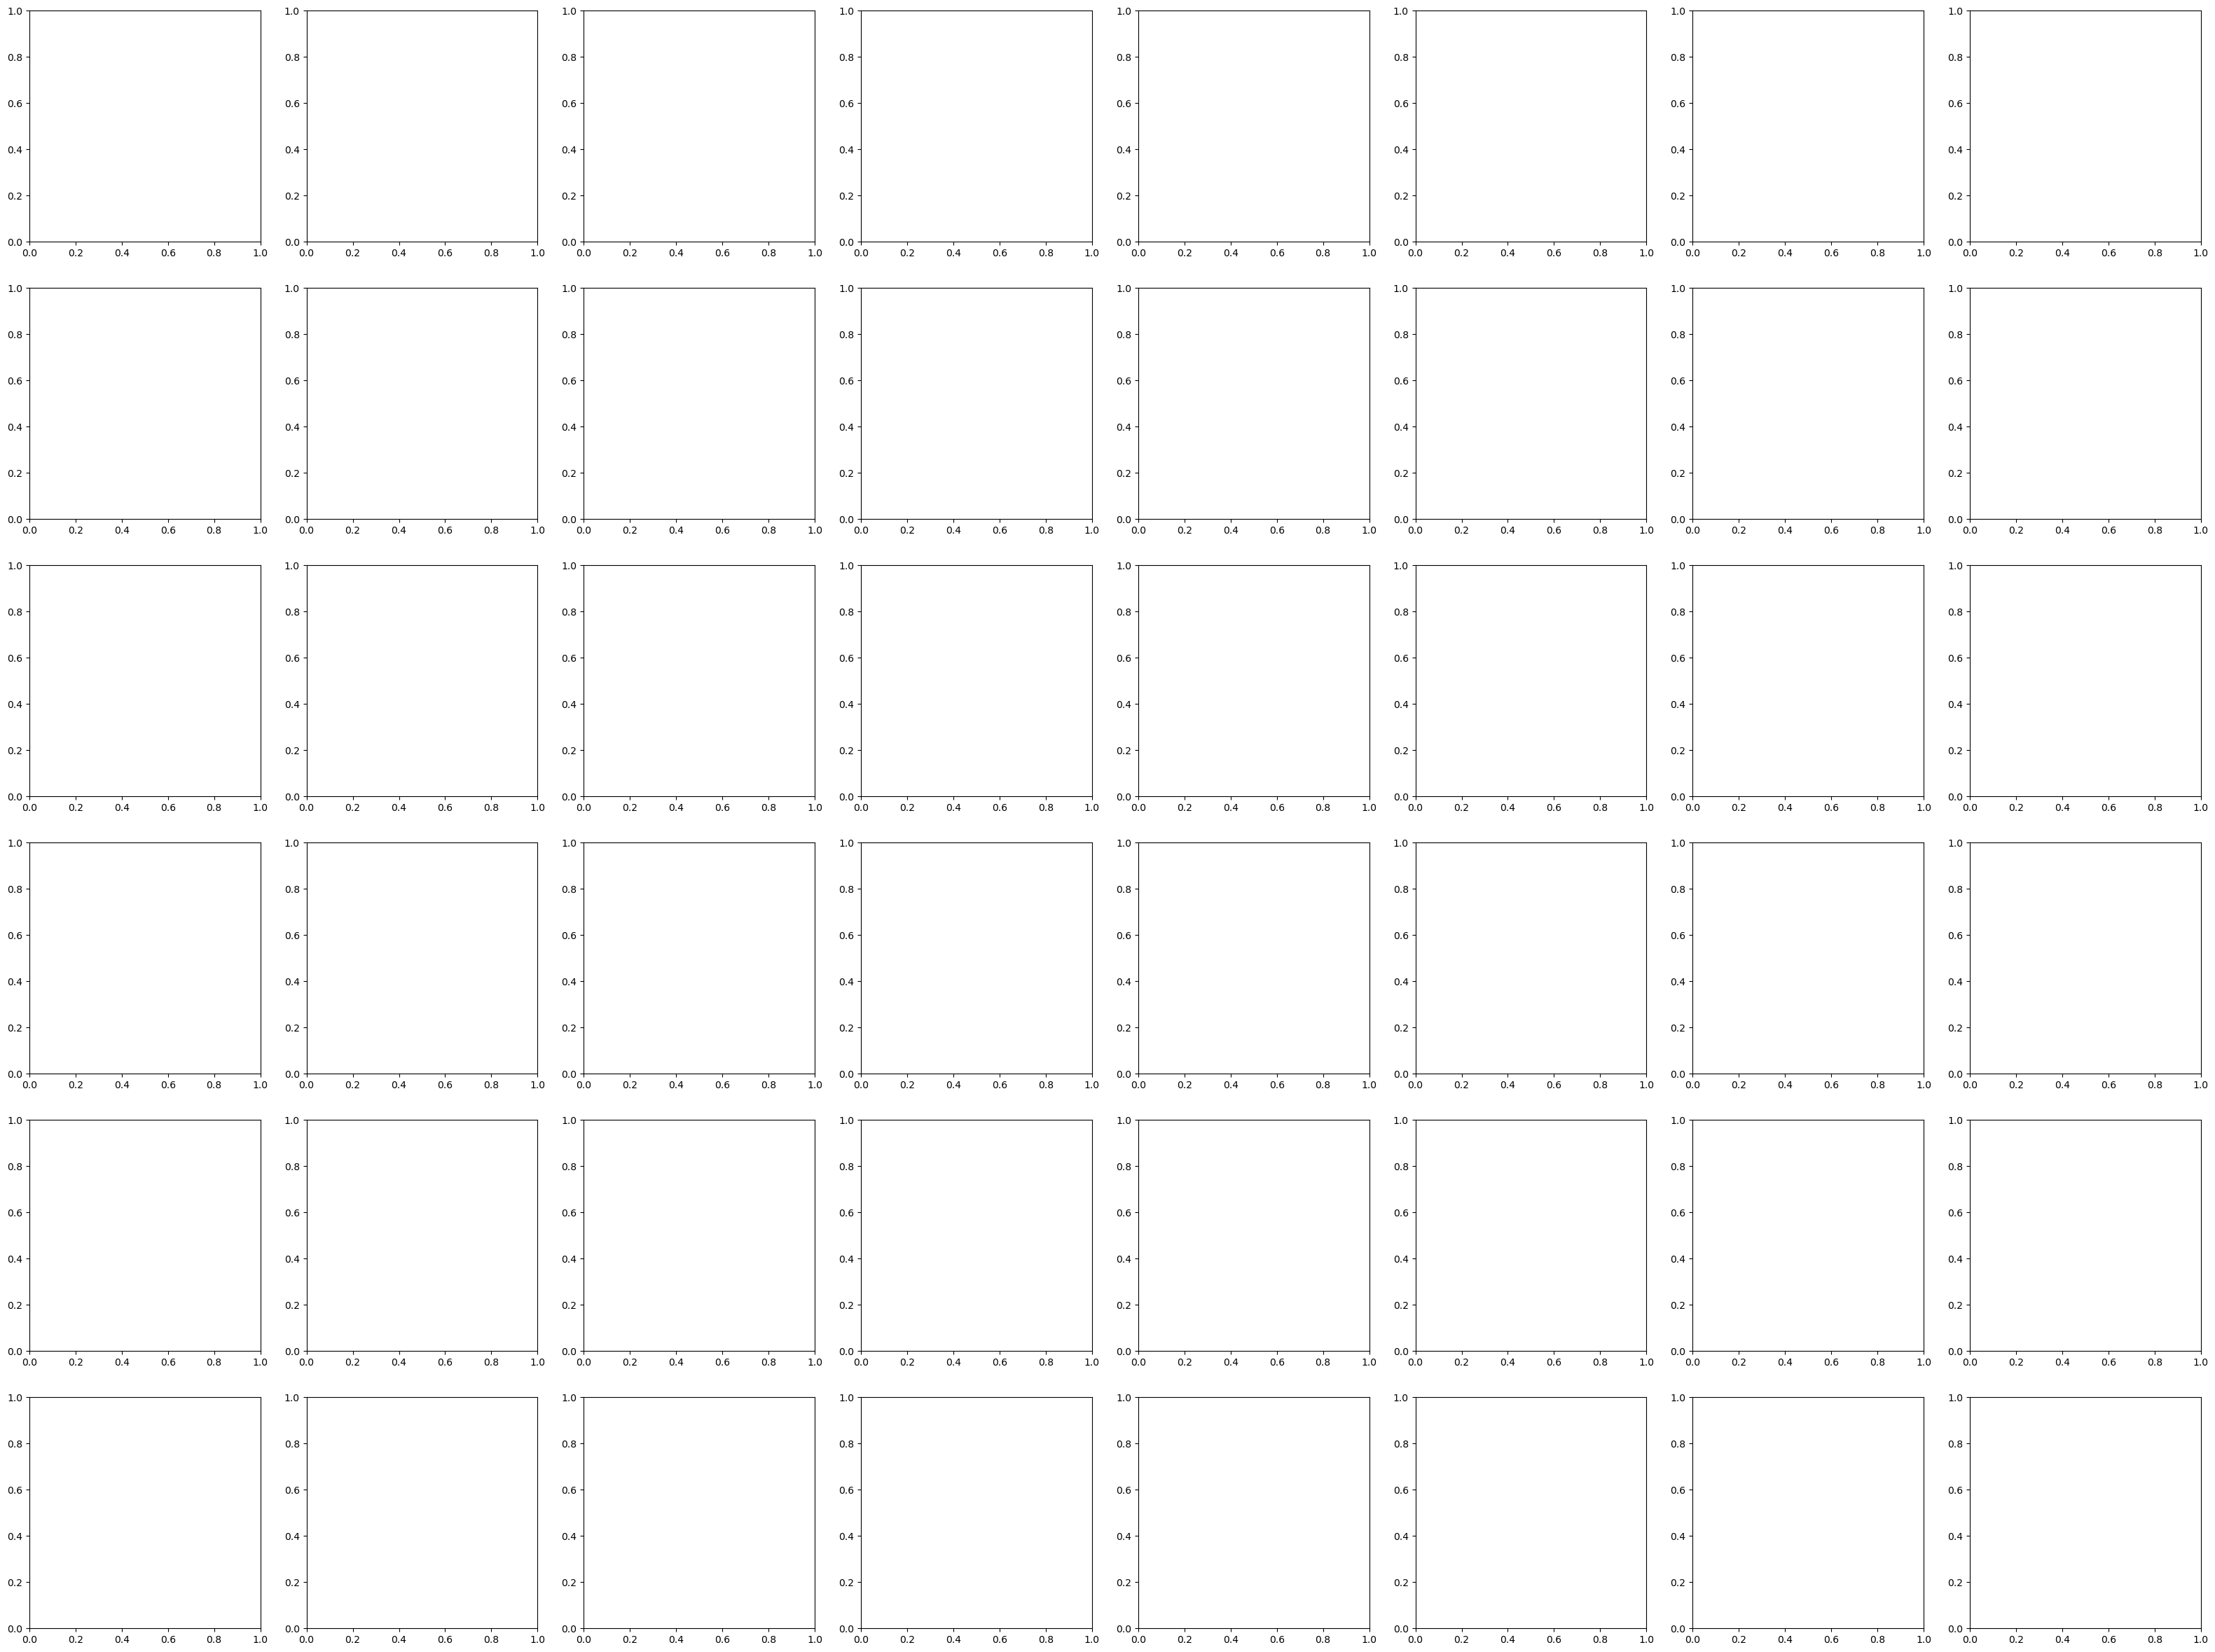

In [23]:
plot_user_images(image_dir="./data/raw/FLICKR-AES-001/40K/",
                      user_df=user_185_imgs,
                      n = 48
                      )

## Image Statistics


In [24]:
image_statistics_df = compute_img_rating_statistics(ratings_df=ratings_df)
min_count = image_statistics_df["count"] >=4
mean_filter = (image_statistics_df["mean"] >= 3.5) | (image_statistics_df["mean"] <= 2.5)
final_filter = min_count & mean_filter
final_statistics_df = image_statistics_df[final_filter]

In [ ]:
plt.figure(figsize=(12, 8))
image_statistics_df.loc[:, image_statistics_df.columns != "image_id"].hist(bins=20, grid=False, figsize=(12, 8), color='skyblue', zorder=2, rwidth=0.9)
plt.tight_layout()
plt.show()

In [ ]:
features_df = pd.DataFrame(image_features.cpu().numpy(), columns=[f"feature_{i}" for i in range(image_features.shape[1])])
features_df = pd.concat([ratings_df["image_id"], features_df], axis=1)
features_df = features_df.groupby("image_id").agg("mean").reset_index()
features_df = features_df[final_filter]
embeddings = features_df.iloc[:, 1:]
features_df

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=final_statistics_df['median'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('PCA of CLIP Embeddings colored by Median Score')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=final_statistics_df['mean'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('PCA of CLIP Embeddings colored by Mean Score')
plt.show()

In [ ]:
# Perform PCA with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(embeddings)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=final_statistics_df['median'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('3D PCA of CLIP Embeddings colored by Median Score')
plt.show()

# Print important PCA metrics
print("Explained variance per component:", pca.explained_variance_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", pca.explained_variance_ratio_.cumsum())

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=final_statistics_df['mean'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('3D PCA of CLIP Embeddings colored by Mean Score')
plt.show()

# Print important PCA metrics
print("Explained variance per component:", pca.explained_variance_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", pca.explained_variance_ratio_.cumsum())

In [ ]:
import numpy as np
sample_size = 2000
sample_indices = np.random.choice(embeddings.shape[0], sample_size, replace=False)
embeddings_sample = embeddings.iloc[sample_indices]
#scores_sample = df['score'].iloc[sample_indices]

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_result = tsne.fit_transform(embeddings_sample)

tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])



plt.figure(figsize=(10, 8))
fig_tsne = plt.scatter(tsne_result[:,0], tsne_result[:,1], c=final_statistics_df.iloc[sample_indices]['median'])
plt.colorbar(fig_tsne)
plt.title('2D t-SNE of Sampled CLIP Embeddings')
plt.show()

In [32]:
count_filter = image_statistics_df["count"] >=4
min_filter = image_statistics_df["min"] == 1
max_filter = image_statistics_df["max"] == 5
median_filter = image_statistics_df["median"] == 5

criterion = count_filter & median_filter
images_filtered = image_statistics_df[criterion]

In [ ]:
plot_filtered_images(image_dir="./data/raw/FLICKR-AES-001/40K/", img_df=images_filtered)

In [ ]:
# Perform t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=final_statistics_df['median'], cmap='viridis', alpha=0.50)
plt.colorbar(scatter)
plt.title('3D t-SNE of CLIP Embeddings colored by Median Score')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=final_statistics_df['mean'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('3D t-SNE of CLIP Embeddings colored by Mean Score')
plt.show()